/tmp/ipykernel_2657860/1605923470.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q = torch.load(q).cuda()
/tmp/ipykernel_2657860/1605923470.py:153: FutureWarning: You

torch.Size([24, 67576, 128]) torch.Size([24, 67576, 128])
torch.Size([24, 67576, 128]) torch.Size([24, 67576, 128])
score on the voxel: 0.0004558563232421875


/tmp/ipykernel_2657860/1605923470.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


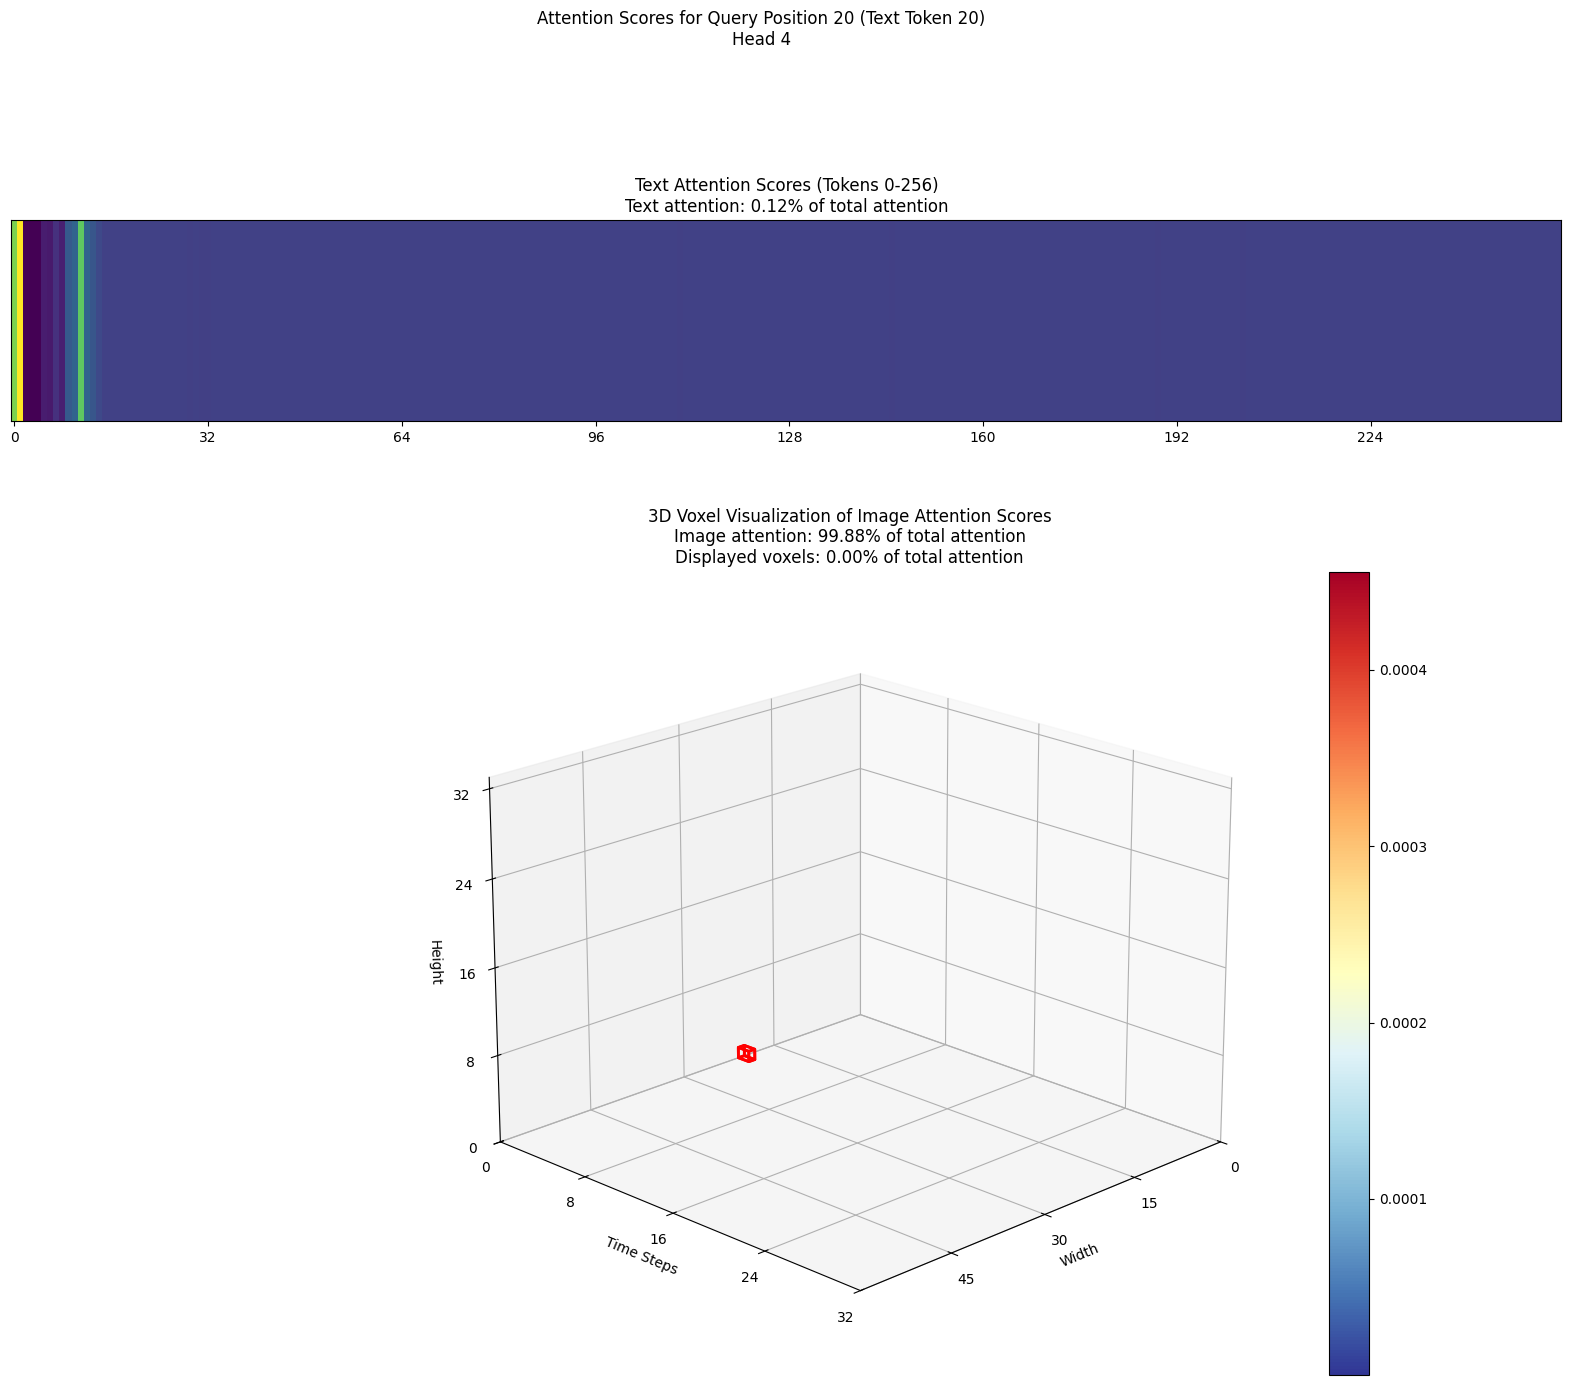

In [24]:
txt_len = 256
T = 33
H = 34
W = 60

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import os

def visualize_attention(attention_matrix, q_pos, head_idx=0):
    from mpl_toolkits.mplot3d import Axes3D
    
    attn_scores = attention_matrix[head_idx, 0, :]
    text_scores = attn_scores[-txt_len:]
    image_scores = attn_scores[:-txt_len]
    image_scores = image_scores.reshape(T, H, W)
    
    # 计算文本和图像的attention总和及百分比
    total_attention = attn_scores.sum()
    text_attention = text_scores.sum()
    image_attention = image_scores.sum()
    text_percentage = (text_attention / total_attention) * 100
    image_percentage = (image_attention / total_attention) * 100
    
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 1, height_ratios=[1, 4], hspace=0.3)
    
    # Text attention visualization
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(text_scores.reshape(1, -1), aspect='auto', cmap='viridis')
    ax1.set_title(f'Text Attention Scores (Tokens 0-256)\n'
                 f'Text attention: {text_percentage:.2f}% of total attention')
    ax1.set_xticks(np.arange(0, txt_len, 32))
    ax1.set_yticks([])
    
    if q_pos < 0:
        rect = patches.Rectangle((-q_pos-0.5, -0.5), 1, 1, 
                               linewidth=2, edgecolor='red', facecolor='none')
        ax1.add_patch(rect)
    
    # 3D visualization using voxels
    ax2 = fig.add_subplot(gs[1], projection='3d')
    ax2.view_init(elev=20, azim=45)
    
    # 创建归一化后的attention scores
    norm = plt.Normalize(image_scores.min(), image_scores.max())
    normalized_scores = norm(image_scores)
    
    # 创建voxel网格
    voxels = np.zeros((W, T, H))
    colors = np.zeros((W, T, H, 4))
    
    # 计算显著voxel的softmax总和
    significant_sum = 0
    
    # 填充voxel数据
    for t in range(T):
        for h in range(H):
            for w in range(W):
                score = normalized_scores[t, h, w]
                raw_score = image_scores[t, h, w]
                if raw_score > 0.01:  # 显著性阈值
                    voxels[w, t, h] = True
                    color = plt.cm.RdYlBu_r(score)
                    colors[w, t, h] = (*color[:3], score)
                    significant_sum += raw_score
    
    # 计算显著voxel占总attention的百分比
    significant_percentage = (significant_sum / total_attention) * 100
    
    # 绘制voxels
    ax2.voxels(voxels, facecolors=colors, edgecolor='none')
    
    # 如果是查询位置所在的帧，用带描边的voxel标记
    if q_pos > 0:
        img_pos = q_pos
        frame_t = img_pos // (H * W)
        remainder = img_pos % (H * W)
        h = remainder // W
        w = remainder % W
        
        # 创建查询点的voxel
        query_voxel = np.zeros((W, T, H), dtype=bool)
        query_voxel[w, frame_t, h] = True
        
        # print score on the voxel
        print(f"score on the voxel: {image_scores[frame_t, h, w]}")
        # 绘制带红色描边的红色半透明voxel
        ax2.voxels(query_voxel, 
                   facecolors=np.array([1, 0, 0, 0.0]),
                  edgecolor='red',
                  linewidth=2)
    
    ax2.set_title(f'3D Voxel Visualization of Image Attention Scores\n'
                 f'Image attention: {image_percentage:.2f}% of total attention\n'
                 f'Displayed voxels: {significant_percentage:.2f}% of total attention')
    
    # 设置坐标轴范围和刻度
    ax2.set_xlim(0, W-1)
    ax2.set_ylim(0, T-1)
    ax2.set_zlim(0, H-1)
    
    ax2.set_xticks(np.arange(0, W, W//4))
    ax2.set_yticks(np.arange(0, T, max(1, T//4)))
    ax2.set_zticks(np.arange(0, H, H//4))
    
    ax2.set_xlabel('Width')
    ax2.set_ylabel('Time Steps')
    ax2.set_zlabel('Height')
    
    # 添加颜色条
    norm = plt.Normalize(image_scores.min(), image_scores.max())
    sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
    plt.colorbar(sm, ax=ax2)
    
    # 设置总标题
    if q_pos < txt_len:
        position_info = f"Text Token {q_pos}"
    else:
        img_pos = q_pos
        t = img_pos // (H * W)
        remainder = img_pos % (H * W)
        h = remainder // W
        w = remainder % W
        position_info = f"Image Position (t={t}, h={h}, w={w})"
    
    plt.suptitle(f'Attention Scores for Query Position {q_pos} ({position_info})\nHead {head_idx}', y=1.02)
    
    plt.tight_layout()
    
def get_attention_matrix(q, k, q_pos):
    # q, k: torch.tensor, shape: (num_heads, seq_len, d_k)
    # return: torch.tensor, shape: (num_heads, seq_len, seq_len)
    qk = torch.matmul(q[:, q_pos:q_pos+1, :], k.transpose(-1, -2)) / (q.size(-1) ** 0.5)
    qk = torch.softmax(qk, dim=-1)
    return qk
        
layer_idx = 1
time_idx = 49
if layer_idx <= 20:
    layer_type = "double"
else:
    layer_type = "single"

root = "/dataset-vlm/yc/FinalProj/FlashVideo/results/results_attn_save"
# load the qk value.
q = os.path.join(root, f"q_{layer_type}_{layer_idx}_{time_idx}.pt")
k = os.path.join(root, f"k_{layer_type}_{layer_idx}_{time_idx}.pt")

q = torch.load(q).cuda()
k = torch.load(k).cuda()
q = q[0, :, :].permute(1, 0, 2)
k = k[0, :, :].permute(1, 0, 2)

print(q.shape, k.shape)
q_pos = 20
print(q.shape, k.shape)

qk = get_attention_matrix(q, k, q_pos).cpu().float()
visualize_attention(qk, q_pos, 4)